**Step 1: Install required libraries**

In [ ]:
!pip install transformers gradio --quiet

**Step 2: Upload and Unzip Fine-Tuned Model**

In [3]:
from google.colab import files
import zipfile
import os

# Uploading your zip file
uploaded = files.upload()

# Saving the filename
zip_filename = list(uploaded.keys())[0]

# Folder to extract the model
extract_folder = "emotion_detection_model"

# Extracting zip
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extracted files/folders:", os.listdir(extract_folder))

model_folder = extract_folder


Saving Goemotions-distilbert-model - Fine-tuning.zip to Goemotions-distilbert-model - Fine-tuning (1).zip
Extracted files/folders: ['model.safetensors', 'training_args.bin', 'special_tokens_map.json', 'tokenizer_config.json', 'vocab.txt', 'config.json']


**Step 3: Load Model and Tokenizer**

In [4]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline

# Loading tokenizer and model from extracted folder
tokenizer = DistilBertTokenizer.from_pretrained(model_folder)
model = DistilBertForSequenceClassification.from_pretrained(model_folder)

# Multi-label classification pipeline with sigmoid
emotion_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


**Step 4: Define label mapping**

In [5]:
# GoEmotions labels
id2label = {
    0: "admiration",
    1: "amusement",
    2: "anger",
    3: "annoyance",
    4: "approval",
    5: "caring",
    6: "confusion",
    7: "curiosity",
    8: "desire",
    9: "disappointment",
    10: "disapproval",
    11: "disgust",
    12: "embarrassment",
    13: "excitement",
    14: "fear",
    15: "gratitude",
    16: "grief",
    17: "joy",
    18: "love",
    19: "nervousness",
    20: "optimism",
    21: "pride",
    22: "realization",
    23: "relief",
    24: "remorse",
    25: "sadness",
    26: "surprise",
    27: "neutral"
}


**Step 5: Define Prediction Function**

In [8]:
# Imports
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Prediction function
def predict_emotion(text, top_k=3):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = F.softmax(outputs.logits, dim=-1)[0]
    top_probs, top_ids = torch.topk(probs, k=top_k)

    results = []
    for i in range(top_k):
        label = id2label[int(top_ids[i])]
        confidence = round(float(top_probs[i]) * 100, 2)
        results.append((label, confidence))

    return results


**Step 6: Quick Test**

In [9]:
test_text = "I am feeling happy"
print("Input:", test_text)
print("Predictions:", predict_emotion(test_text))


Input: I am feeling happy
Predictions: [('joy', 91.96), ('excitement', 1.96), ('approval', 0.91)]


**Step 7: Launch Gradio UI**

In [10]:
import gradio as gr

def gradio_predict(text):
    predictions = predict_emotion(text, top_k=3)  # get top 3
    results = {label: float(score) for label, score in predictions}
    return results

# Launching the Gradio interface
demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=2, placeholder="Type your text here..."),
    outputs=gr.Label(num_top_classes=3),
    title="Emotion Detection UI",
    description="Enter text and get the top 3 predicted emotions with confidence scores."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1bcd60d0e377a1cd42.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Step 8: Visualization of Top 3 Predictions**

Input: I am feeling happy and grateful today.
- joy: 62.4%
- gratitude: 53.3%
- excitement: 6.8%


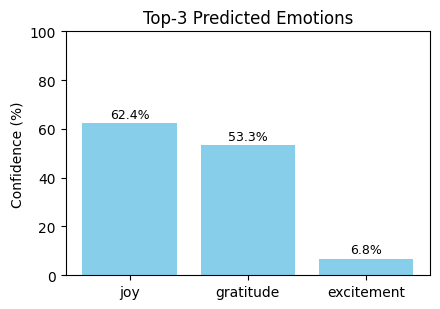

In [16]:
import torch
import matplotlib.pyplot as plt

# Defining GoEmotions label list (28 emotions + neutral)
emotion_labels = [
    'admiration','amusement','anger','annoyance','approval','caring','confusion',
    'curiosity','desire','disappointment','disapproval','disgust','embarrassment',
    'excitement','fear','gratitude','grief','joy','love','nervousness','optimism',
    'pride','realization','relief','remorse','sadness','surprise','neutral'
]

def predict_top3(text):
    """Return top-3 (label, percent) pairs and full probability vector."""
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Forward pass (multi-label classification → sigmoid)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy().ravel()

    # Getting top-3
    top_idx = probs.argsort()[-3:][::-1]
    top_labels = [emotion_labels[i] for i in top_idx]
    top_scores = [float(probs[i] * 100.0) for i in top_idx]
    return list(zip(top_labels, top_scores))

def show_top3_bar(text):
    """Print and plot the top-3 predictions."""
    top3 = predict_top3(text)

    print("Input:", text)
    for lbl, pct in top3:
        print(f"- {lbl}: {pct:.1f}%")

    labels = [lbl for lbl, _ in top3]
    scores = [pct for _, pct in top3]

    plt.figure(figsize=(4.5, 3.2))
    bars = plt.bar(labels, scores, color="skyblue")
    plt.ylim(0, 100)
    plt.ylabel("Confidence (%)")
    plt.title("Top-3 Predicted Emotions")

    # Adding labels above bars
    for b, s in zip(bars, scores):
        plt.text(b.get_x() + b.get_width()/2, b.get_height() + 1,
                 f"{s:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

# ---- Example run ----
test_text = "I am feeling happy and grateful today."
show_top3_bar(test_text)
